# (A) Dependencies

## Installations

In [1]:
!!pip install transformers
#pip install transformers==4.20.0
!pip install keras-nlp --upgrade
#!pip install keras_nlp==0.3.0
!pip install rouge-score
!pip install datasets
!pip install huggingface-hub
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 KB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 109.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tens

In [2]:
import keras_nlp
rouge_l = keras_nlp.metrics.RougeL()

## Libraries

In [3]:
import os
import logging

import nltk
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Only log error messages
tf.get_logger().setLevel(logging.ERROR)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Configurations

In [4]:
# splti ratio for dataset
TRAIN_TEST_SPLIT = 0.1

# model hyperparams
MAX_INPUT_LENGTH = 1024  
MIN_TARGET_LENGTH = 5  
MAX_TARGET_LENGTH = 128  
BATCH_SIZE = 8  
LEARNING_RATE = 2e-5  
MAX_EPOCHS = 10  

# pretrained model name from Hugging Face Model Hub
MODEL_CHECKPOINT = "t5-small"

# (B) Dataset

## Load the dataset

- [Hugging Face Datasets](https://github.com/huggingface/datasets) 

In [5]:
# Downloading the dataset
from datasets import load_dataset
raw_datasets = load_dataset("xsum", split="train")

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71. Subsequent calls will reuse this data.


The dataset has the following fields:

- **document**: the original BBC article to me summarized
- **summary**: the single sentence summary of the BBC article
- **id**: ID of the document-summary pair

In [6]:
print(raw_datasets)

Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 204045
})


In [7]:
print(raw_datasets[0])

{'document': 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally apprecia

## Train-test split

In [8]:
# Train-Test Split
raw_datasets = raw_datasets.train_test_split(
    train_size=TRAIN_TEST_SPLIT, test_size=TRAIN_TEST_SPLIT
)

# (C) Pre-processing


## Tokenizing

In [9]:
# Downloading the pre-trained tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [10]:
# setting the configuration param of the preprocessing
val_models = ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]
prefix = prefix = "summarize: " if MODEL_CHECKPOINT in val_models else ""

## Implementing Pre-processing

In [11]:
def preprocess_function(examples):
    # Tokenizing the data
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True)

    # Setting the targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["summary"], max_length=MAX_TARGET_LENGTH, truncation=True
        )
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


In [12]:
# pre-processing via tokenizer
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/20404 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/20405 [00:00<?, ? examples/s]

# (D) Modelling

## Downloading the pretrained model

In [ ]:
from google.colab import drive
drive.mount("drive")

In [ ]:
!cp -r /content/drive/MyDrive/Home/Projects/TextSummarization/fine_tuned_sum /content/

In [13]:
#Downloading the mdoel
from transformers import TFAutoModelForSeq2SeqLM
#model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)
model = TFAutoModelForSeq2SeqLM.from_pretrained("fine_tuned_sum")

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [14]:
# Building the model
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


## Adjusting the dataset notation according to model

In [15]:
# Creating the configuration object for tf dataset
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

In [16]:
train_dataset = tokenized_datasets["train"].to_tf_dataset(
    batch_size=BATCH_SIZE,
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    collate_fn=data_collator,
)
test_dataset = tokenized_datasets["test"].to_tf_dataset(
    batch_size=BATCH_SIZE,
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=False,
    collate_fn=data_collator,
)
generation_dataset = (
    tokenized_datasets["test"]
    .shuffle()
    .select(list(range(200)))
    .to_tf_dataset(
        batch_size=BATCH_SIZE,
        columns=["input_ids", "attention_mask", "labels"],
        shuffle=False,
        collate_fn=data_collator,
    )
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


## Training

### Custom metric

In [17]:
!pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import keras_nlp
rouge_l = keras_nlp.metrics.RougeL()

def metric_fn(eval_predictions):

    # decoding the predictions
    predictions, labels = eval_predictions
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace masked label tokens then decoding the labels 
    for label in labels: label[label < 0] = tokenizer.pad_token_id  
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # scoring
    result = rouge_l(decoded_labels, decoded_predictions)

    return {"RougeL": result["f1_score"]}

### Callbacks

In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger,
                                        LearningRateScheduler, ReduceLROnPlateau, LambdaCallback)
import numpy as np

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

def print_current_lr(epoch, logs):
    print("Learning rate in epoch {} is {}".format(epoch, float(tf.keras.backend.get_value(model.optimizer.lr))))


from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(
    metric_fn, eval_dataset=generation_dataset, predict_with_generate=True
)

# Temporary save paths
checkpoint_path = "fine_tuned_sum"
tb_log_dir = "./logs"

In [25]:
callbacks = [
    #LearningRateScheduler(step_decay),
    #metric_callback,
    TensorBoard(log_dir=tb_log_dir),
    ModelCheckpoint(filepath= checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, restore_best_weights=True, verbose=1),
    CSVLogger(filename='training.log'),
    #LambdaCallback(on_epoch_end=print_current_lr)
]

### Training

In [26]:
# preparing the training params
t_p = {
  "validation_data":test_dataset, 
  "epochs":1,#MAX_EPOCHS,
  "callbacks":callbacks
}

# training the model
history = model.fit(train_dataset, **t_p)

Epoch 1/100
2551/2551 [==============================] - ETA: 0s - loss: 2.7086
Epoch 1: val_loss improved from inf to 2.50005, saving model to fine_tuned_text_sum_model
2551/2551 [==============================] - 2176s 853ms/step - loss: 2.7086 - val_loss: 2.5000
Epoch 2/100
2551/2551 [==============================] - ETA: 0s - loss: 2.6702
Epoch 2: val_loss improved from 2.50005 to 2.48179, saving model to fine_tuned_text_sum_model
2551/2551 [==============================] - 2168s 850ms/step - loss: 2.6702 - val_loss: 2.4818
Epoch 3/100
2551/2551 [==============================] - ETA: 0s - loss: 2.6366
Epoch 3: val_loss improved from 2.48179 to 2.46617, saving model to fine_tuned_text_sum_model
2551/2551 [==============================] - 2174s 852ms/step - loss: 2.6366 - val_loss: 2.4662
Epoch 4/100
 645/2551 [======>.......................] - ETA: 20:08 - loss: 2.6119

KeyboardInterrupt: ignored

In [ ]:
history.history

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim((0, 9))

plt.legend()

In [27]:
loss = [2.7086, 2.6702, 2.6366]
val_loss = [2.5, 2.4818, 2.4662]

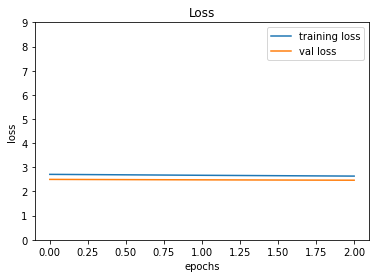

In [28]:
import matplotlib.pyplot as plt

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim((0, 9))

plt.legend()

## Prediction

In [29]:
from transformers import pipeline

summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, framework="tf")

summarizer(
    raw_datasets["test"][0]["document"],
    min_length=MIN_TARGET_LENGTH,
    max_length=MAX_TARGET_LENGTH,
)

Your max_length is set to 128, but you input_length is only 114. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
/usr/local/lib/python3.9/dist-packages/transformers/generation/tf_utils.py:745: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


[{'summary_text': 'New Zealand have won the 2025 World Cup for the first time since 1990, beating New Zealand in the final of the World Cup.'}]

In [30]:
examples = [
    raw_datasets["test"][i]["document"]
    for i in range(5)
]
    

In [39]:
import pickle

with open('examples.pkl', 'wb') as f: pickle.dump(examples, f)
with open('examples.pkl', 'rb') as f: loaded_examples = pickle.load(f)

In [41]:
from google.colab import files
files.download("examples.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
loaded_examples[0]

'The Scots held New Zealand to an 18-18 draw in the recent Four Nations, becoming the first side from outside the top three to avoid defeat by the Kiwis, Australia or England since 1990.\nAustralia usurp New Zealand as world number one after hammering their rivals 34-8 in the Four Nations final.\nEngland stay third, with Ireland eighth and Wales ninth.\nUSA and Canada, who have been jointly awarded the 2025 World Cup, appear in the top 12 nations for the first time at 10th and 12th respectively.'

# (E) Saving the model

## Save the best model

In [ ]:
# Load the best weights
#model.load_weights(checkpoint_path)

In [42]:
best_model_save_path = f"fine_tuned_sum" 
model.save_pretrained(best_model_save_path)

In [43]:
tokenizer_save_path = "tokenizer"
tokenizer.save_pretrained(tokenizer_save_path)

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/tokenizer.json')

## Compressing the model

In [44]:
dst, src = f"{best_model_save_path}.zip", best_model_save_path

In [45]:
import os 
# Zipping the model to download
os.system(f"zip -r {dst} {src}")

0

In [46]:
os.system(f"zip -r tokenizer.zip tokenizer")

0

## Download the model

In [47]:
# Downloading the zipped model into the local
from google.colab import files
files.download(dst)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


In [49]:
!cp -r /content/fine_tuned_sum /content/drive/MyDrive/Home/Projects/TextSummarization

In [50]:
files.download("tokenizer.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
!cp -r /content/tokenizer /content/drive/MyDrive/Home/Projects/TextSummarization

# (F) Deployment as App

## APP (loading from file)

### Declerations & Util Funcs

In [1]:
import os
if os.system("pip freeze | grep gradio==") != 0: os.system("pip install gradio")
if os.system("pip freeze | grep transformers==") != 0: os.system("pip install transformers")

In [2]:
import transformers
import gradio as gr
import numpy as np
import pickle
import nltk

In [3]:
!unzip tokenizer.zip

Archive:  tokenizer.zip
   creating: tokenizer/
  inflating: tokenizer/tokenizer_config.json  
  inflating: tokenizer/special_tokens_map.json  
  inflating: tokenizer/tokenizer.json  


In [ ]:
#!unzip  fine_tuned_bert.zip

Archive:  fine_tuned_bert.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of fine_tuned_bert.zip or
        fine_tuned_bert.zip.zip, and cannot find fine_tuned_bert.zip.ZIP, period.


In [4]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


In [14]:
!cp -r /content/drive/MyDrive/Home/Projects/TextSummarization/fine_tuned_sum /content/

In [15]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, pipeline

# File Paths
model_path = 'fine_tuned_sum' 
tokenizer_path = "tokenizer"
examples_path = "examples.pkl"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# Load the fine-tuned BERT model
seq2seq_model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

# loading the examples
with open('examples.pkl', 'rb') as f: examples = pickle.load(f)

# Creating the pipeline
sum_params = {
    "model":seq2seq_model,
    "tokenizer":tokenizer,
    "framework":"tf",
}

summarizer = pipeline("summarization", **sum_params)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at fine_tuned_sum.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [16]:
# Define a function to make predictions with the model
def summarize(text):

    # defining the params
    prms = {
        "min_length":5,
        "max_length":128
    }
    return summarizer(text,**prms)[0]["summary_text"]

### Text Summarizer app

In [17]:
import gradio as gr

# defining the params
if_p = {
    "fn":summarize,
    "inputs":gr.inputs.Textbox(label="Text"),
    "outputs":gr.outputs.Textbox(label="Output"),
    "title":"Fine-tuned BERT moedl for text generation",
    "description":"Write something to generate text",
    "examples":examples
}

# Create a Gradio interface instance
iface = gr.Interface(**if_p)

/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


In [18]:
# Launch the interface
iface.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>